# Лабораторна робота №3
## Класифікація зображень. Застосування нейромереж для пошуку подібних зображень.
Варіант - 10

Побудувати CNN на основі ResNeXt-50 для класифікації зображень на основі датасету fashion-mnist. Зробити налаштування моделі для досягнення необхідної точності. На базі Siamese networks побудувати систему для пошуку подібних зображень в датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import Model, layers, models

In [ ]:
train = pd.read_csv("fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist_test.csv")

In [ ]:
X_train = train.iloc[:, 1:].values
y_train = train.iloc[:, :1].values

X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, :1].values

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255

print('Training', X_train.shape, X_train.max())
print('Testing', X_test.shape, X_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [ ]:
train_groups = [X_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [X_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
model = keras.Sequential([
    layers.Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    layers.Conv2D(128, (1,1), strides=(1,1), padding='valid', activation='relu'),
    layers.Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1,1), strides=(1,1), padding='valid', activation='relu'),
    layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (1,1), strides=(1,1), padding='valid', activation='relu'),
    layers.Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(1024, (1,1), strides=(1,1), padding='valid', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10)
])

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 30s 10ms/step - loss: 0.4294 - accuracy: 0.8421 - val_loss: 0.3998 - val_accuracy: 0.8534
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3044 - accuracy: 0.8881 - val_loss: 0.3197 - val_accuracy: 0.8876
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2695 - accuracy: 0.8989 - val_loss: 0.4052 - val_accuracy: 0.8548
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2438 - accuracy: 0.9099 - val_loss: 0.2613 - val_accuracy: 0.9062
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2211 - accuracy: 0.9169 - val_loss: 0.2443 - val_accuracy: 0.9062
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2012 - accuracy: 0.9251 - val_loss: 0.2369 - val_accuracy: 0.9124
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1833 - accuracy: 0.9308 - val_loss: 0.2523 -

In [ ]:
scores = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2400 - accuracy: 0.9171


In [ ]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
                      for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx])
                            for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
                      for c_idx in b_group_idx]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

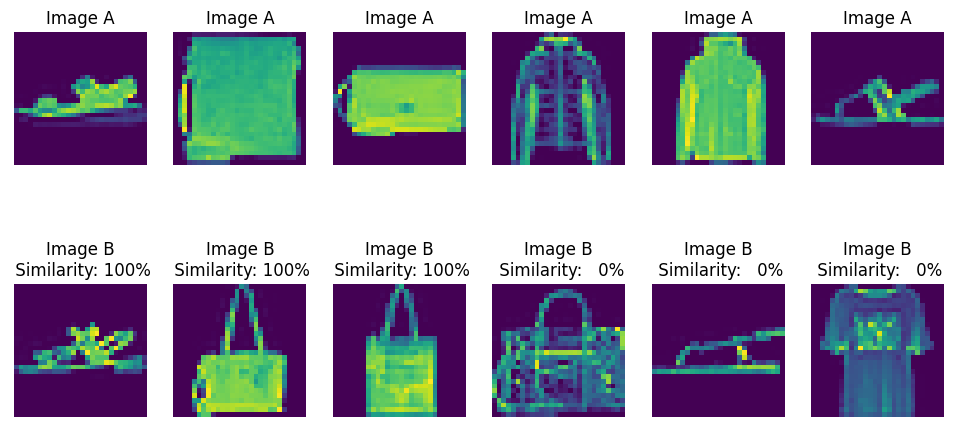

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [ ]:
img_a_in = layers.Input(shape=X_train.shape[1:], name='ImageA_Input')
img_b_in = layers.Input(shape=X_train.shape[1:], name='ImageB_Input')
img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = layers.Dense(256, activation='linear')(combined_features) #16
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)
combined_features = layers.Dense(128, activation='linear')(combined_features) #4
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation('relu')(combined_features)
combined_features = layers.Dense(1, activation='sigmoid')(combined_features)
siamese_model = models.Model(
                              inputs=[img_a_in, img_b_in], 
                              outputs=[combined_features],
                              name='SiameseModel'
                              )
siamese_model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           3813002     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['sequential[0][0]',  

In [ ]:
siamese_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

1/1 [==============================] - 1s 903ms/step


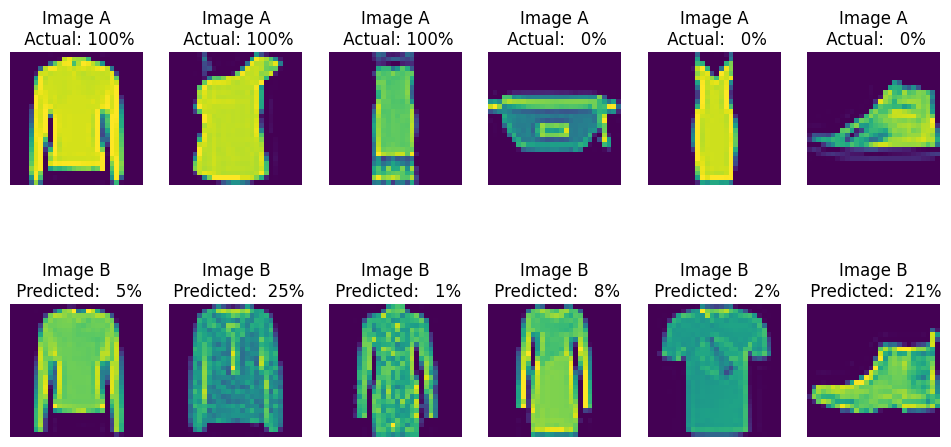

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit_generator(
                                              siam_gen(train_groups),
                                              steps_per_epoch=500,
                                              validation_data=([valid_a, valid_b], valid_sim),
                                              epochs=10,
                                              verbose=True,
                                              )

Epoch 1/10


<ipython-input-15-a98dd045ef87>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = siamese_model.fit_generator(


500/500 [==============================] - 30s 47ms/step - loss: 0.1488 - mae: 0.0955 - val_loss: 0.1960 - val_mae: 0.0875
Epoch 2/10
500/500 [==============================] - 21s 43ms/step - loss: 0.1142 - mae: 0.0669 - val_loss: 0.1789 - val_mae: 0.0834
Epoch 3/10
500/500 [==============================] - 22s 44ms/step - loss: 0.1031 - mae: 0.0593 - val_loss: 0.1620 - val_mae: 0.0773
Epoch 4/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0983 - mae: 0.0567 - val_loss: 0.1711 - val_mae: 0.0723
Epoch 5/10
500/500 [==============================] - 21s 42ms/step - loss: 0.0990 - mae: 0.0561 - val_loss: 0.1456 - val_mae: 0.0665
Epoch 6/10
500/500 [==============================] - 33s 65ms/step - loss: 0.0983 - mae: 0.0565 - val_loss: 0.1757 - val_mae: 0.0745
Epoch 7/10
500/500 [==============================] - 22s 43ms/step - loss: 0.0936 - mae: 0.0541 - val_loss: 0.1686 - val_mae: 0.0740
Epoch 8/10
500/500 [==============================] - 23s 45ms/step - los

1/1 [==============================] - 0s 22ms/step


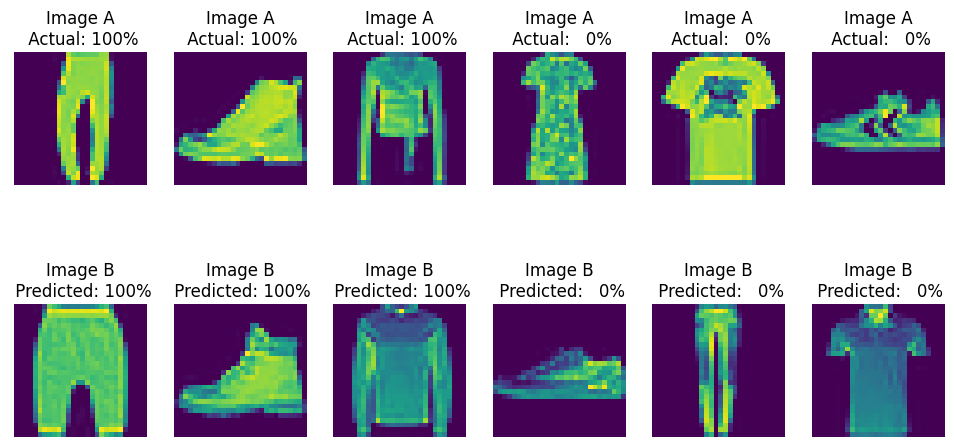

In [ ]:
_ = show_model_output()

In [ ]:
from sklearn.manifold import TSNE

X_test_features = model.predict(X_test, verbose=True, batch_size=128)

tsne_obj = TSNE(
    n_components=2,
    init="pca",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=1,
)
tsne_features = tsne_obj.fit_transform(X_test_features)

79/79 [==============================] - 1s 6ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 0.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.497153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.517464
[t-SNE] KL divergence afte

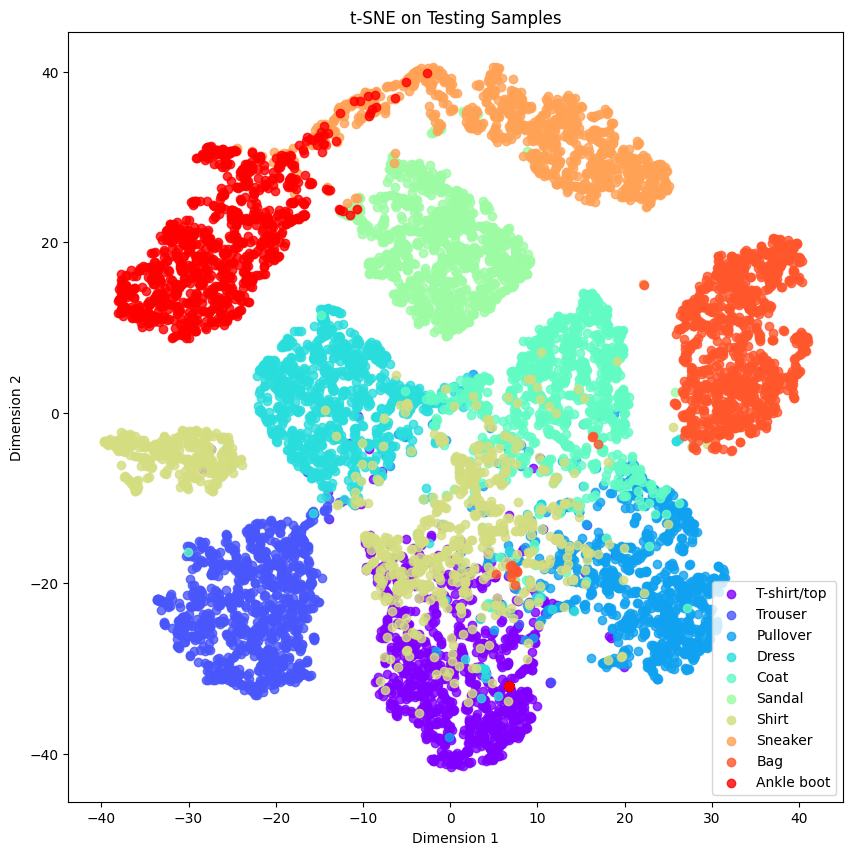

In [ ]:
obj_categories = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label,
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)